# Computational Social Science Project #2 

*Group number:* 

*Group members:*   
Rachel Pizatella-Haswell, Brenda Sciepura, Omair Gil

*Semester:* Fall 2023


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

## 1. Introduction/Setup

#### a) Import relevant libraries
Add the other libraries you need for your code below and/or as you go. 

In [1]:
# import libraries you might need here 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import geopandas as gpd

#Import specific sklearn functions
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. 

In [2]:
os.getcwd()

'/Users/saa0726/Documents/CSS/Computational-Social-Science-Projects/project_2'

In [3]:
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       #CountyFips needs to be a string so leading 0 isn't dropped (this is only if you want to make choropleth map): 
                       dtype={"CountyFIPS": str}) 

In [4]:
diabetes

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,...,sex and age_total population_21 years and over,sex and age_total population_62 years and over,sex and age_total population_65 years and over,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female
0,Autauga County,Alabama,01001,5178,13489,12525,76.5,55200,54170,1030,...,39614,9403,8050,41831,20054,21777,92.1,8050,3488,4562
1,Baldwin County,Alabama,01003,16707,48542,40024,86.6,208107,204535,3572,...,155502,49811,40665,162430,78104,84326,92.6,40665,18870,21795
2,Barbour County,Alabama,01005,3400,8009,5431,76.2,25782,25429,353,...,19394,5658,4634,20346,10923,9423,115.9,4634,2004,2630
3,Bibb County,Alabama,01007,2371,6534,5827,80.5,22527,22340,187,...,16864,4323,3661,17868,9578,8290,115.5,3661,1633,2028
4,Blount County,Alabama,01009,6282,14227,14365,79.7,57645,56710,935,...,42232,12400,10233,44177,21595,22582,95.6,10233,4540,5693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,Sweetwater County,Wyoming,56037,2560,9362,7518,92.0,44117,43226,891,...,30491,6159,4721,32308,16800,15508,108.3,4721,2262,2459
3216,Teton County,Wyoming,56039,439,2051,2005,94.8,23059,22875,184,...,18169,3843,3135,18625,9619,9006,106.8,3135,1526,1609
3217,Uinta County,Wyoming,56041,1440,4925,3519,97.6,20609,19891,718,...,13939,3251,2498,14538,7280,7258,100.3,2498,1234,1264
3218,Washakie County,Wyoming,56043,637,1738,1708,89.0,8129,7791,338,...,5951,2041,1686,6187,3142,3045,103.2,1686,794,892


In [5]:
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [6]:
pd.set_option('display.max_rows', 100) # tells pandas how many rows to display when printing so results don't get truncated

# look at the data types for each column in diabetes df 
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [7]:
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [8]:
diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,...,sex and age_total population_21 years and over,sex and age_total population_62 years and over,sex and age_total population_65 years and over,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female
2751,Loving County,Texas,48301,Suppressed,26,21,150.0,102,102,0,...,78,31,25,78,47,31,151.6,25,15,10


In [9]:
# Now do the same as above, but for "Obesity_Number" :
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 

['No Data']


In [10]:
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']

0       76.5
1       86.6
2       76.2
3       80.5
4       79.7
        ... 
3215    92.0
3216    94.8
3217    97.6
3218    89.0
3219    90.6
Name: sex and age_total population_65 years and over_sex ratio (males per 100 females), Length: 3220, dtype: object

The values contained in the two columns above making them objects (rather than integers) appear to be strings like "No Data" and "Suppressed." Let's drop those rows in the next section, and also recode Physical_Inactivity_Number to be an integer. 

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' to. 

In [11]:
# Diabetes
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"]  # note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 

In [12]:
assert not (diabetes['Diabetes_Number'] == 'Suppressed').any()

In [13]:
diabetes = diabetes[diabetes['Obesity_Number']!='No Data']

In [14]:
diabetes[['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number']] = diabetes[['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number']].astype(int) 

In [15]:
diabetes[['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number']].dtypes

Diabetes_Number               int64
Obesity_Number                int64
Physical_Inactivity_Number    int64
dtype: object

In [16]:
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

In [17]:
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].head()

0    76.5
1    86.6
2    76.2
3    80.5
4    79.7
Name: sex and age_total population_65 years and over_sex ratio (males per 100 females), dtype: object

In [19]:
# change to numeric (specifically, integer or float?) from string (because originally included the "-" )
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

In [20]:
diabetes['total housing units']

0        23315
1       111945
2        11937
3         9161
4        24222
         ...  
3215     19628
3216     13680
3217      8972
3218      3868
3219      3565
Name: total housing units, Length: 3112, dtype: int64

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [21]:
# select count variables to rc to percentages; make sure we leave out ratios and our population variable b/c these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'sex and age_total population_sex ratio (males per 100 females)', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population', 'total housing units',]]

In [22]:
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') # recode all selected columns to numeric

In [23]:
# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

In [24]:
diabetes

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,...,sex and age_total population_21 years and over,sex and age_total population_62 years and over,sex and age_total population_65 years and over,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female
0,Autauga County,Alabama,01001,0.093804,0.244366,0.226902,76.5,55200,0.981341,0.018659,...,0.717645,0.170344,0.145833,0.757808,0.363297,0.394511,92.1,0.145833,0.063188,0.082645
1,Baldwin County,Alabama,01003,0.080281,0.233255,0.192324,86.6,208107,0.982836,0.017164,...,0.747221,0.239353,0.195404,0.780512,0.375307,0.405205,92.6,0.195404,0.090675,0.104730
2,Barbour County,Alabama,01005,0.131875,0.310643,0.210651,76.2,25782,0.986308,0.013692,...,0.752230,0.219455,0.179738,0.789155,0.423668,0.365488,115.9,0.179738,0.077729,0.102009
3,Bibb County,Alabama,01007,0.105251,0.290052,0.258667,80.5,22527,0.991699,0.008301,...,0.748613,0.191903,0.162516,0.793182,0.425179,0.368003,115.5,0.162516,0.072491,0.090025
4,Blount County,Alabama,01009,0.108977,0.246804,0.249198,79.7,57645,0.983780,0.016220,...,0.732622,0.215110,0.177518,0.766363,0.374621,0.391743,95.6,0.177518,0.078758,0.098760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,Sweetwater County,Wyoming,56037,0.058028,0.212208,0.170410,92.0,44117,0.979804,0.020196,...,0.691139,0.139606,0.107011,0.732325,0.380806,0.351520,108.3,0.107011,0.051273,0.055738
3216,Teton County,Wyoming,56039,0.019038,0.088946,0.086951,94.8,23059,0.992020,0.007980,...,0.787935,0.166659,0.135956,0.807711,0.417147,0.390563,106.8,0.135956,0.066178,0.069778
3217,Uinta County,Wyoming,56041,0.069872,0.238973,0.170751,97.6,20609,0.965161,0.034839,...,0.676355,0.157747,0.121209,0.705420,0.353244,0.352176,100.3,0.121209,0.059877,0.061332
3218,Washakie County,Wyoming,56043,0.078361,0.213802,0.210112,89.0,8129,0.958420,0.041580,...,0.732070,0.251076,0.207406,0.761102,0.386517,0.374585,103.2,0.207406,0.097675,0.109731


Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [25]:
pd.set_option('display.max_columns', None)
# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
diabetes_summary

,count,mean,std,min,25%,50%,75%,max
Diabetes_Number,3112.0,0.092857,0.028097,0.019038,0.072169,0.089291,0.110175,2.242079e-01
Obesity_Number,3112.0,0.251666,0.044323,0.088946,0.223436,0.252390,0.280113,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.044511,0.064949,0.170128,0.199036,0.231041,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,10.347722,34.700000,78.300000,82.600000,88.400000,2.200000e+02
race_total population,3112.0,103682.624036,331362.542093,228.000000,11226.750000,26137.500000,68477.250000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.019379,0.713126,0.971038,0.980119,0.986630,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.019379,0.000000,0.013370,0.019881,0.028962,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.019379,0.713126,0.971038,0.980119,0.986630,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.167534,0.038912,0.767171,0.896086,0.950193,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.144287,0.000000,0.006815,0.022927,0.101805,8.741228e-01


In [26]:
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


In [27]:
for col in rc_cols:
    condition = (diabetes[col] >= 0) & (diabetes[col] <= 1)
    assert condition.all(), f"Not all values in {col} are bounded by 0 and 1."

#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. 

In [28]:
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_one race_1',
 'hispanic or latino and race_total population',
 'sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1']

In [29]:
diabetes.loc[:,['hispanic or latino and race_total population',
 'sex and age_total population_18 years and over_1',
 'race_total population_two or more races_1',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'race_total population_one race_1']]

,hispanic or latino and race_total population,sex and age_total population_18 years and over_1,race_total population_two or more races_1,sex and age_total population_65 years and over_1,sex and age_total population,race_total population_one race_1
0,1.0,0.757808,0.018659,0.145833,1.0,0.981341
1,1.0,0.780512,0.017164,0.195404,1.0,0.982836
2,1.0,0.789155,0.013692,0.179738,1.0,0.986308
3,1.0,0.793182,0.008301,0.162516,1.0,0.991699
4,1.0,0.766363,0.016220,0.177518,1.0,0.983780
...,...,...,...,...,...,...
3215,1.0,0.732325,0.020196,0.107011,1.0,0.979804
3216,1.0,0.807711,0.007980,0.135956,1.0,0.992020
3217,1.0,0.705420,0.034839,0.121209,1.0,0.965161
3218,1.0,0.761102,0.041580,0.207406,1.0,0.958420


In [30]:
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

In [31]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
      'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

In [32]:
# Print to verify'Region' column has been added
diabetes

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

### Exploring geographic variation in diabetes prevalence
Because we are interested in understanding which counties to target for a diabetes prevention program, the geographic variation in diabetes prevalence is of particular importance. Depending on the aims of the policymaker, we may be interested in targeting regions that have multiple counties with high diabetes prevalence. Introducing the prevention program in a high risk region could have the benefit of better utilizing the fixed costs that would be necessary toget the program up and running in order eventually scale up and reach more counties. Furthermore, we might expect that the benefits of a successful program pilot could spill over to neighboring counties with similarly high diabetes prevalence. 

### Read in US county shapefile from the UC census and merge to the diabetes dataset

In [33]:
gdf = gpd.read_file('cb_2018_us_county_500k.shp')

In [34]:
gdf[gdf['STATEFP'] == "01"]

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
16,01,001,00161526,0500000US01001,01001,Autauga,06,1539602123,25706961,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
17,01,005,00161528,0500000US01005,01005,Barbour,06,2292144655,50538698,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
18,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869835,19144469,"POLYGON ((-88.47323 31.89386, -88.46888 31.930..."
19,01,035,00161543,0500000US01035,01035,Conecuh,06,2202007854,6632046,"POLYGON ((-87.42720 31.26436, -87.42551 31.268..."
20,01,051,00161551,0500000US01051,01051,Elmore,06,1601769095,99957723,"POLYGON ((-86.41333 32.75059, -86.37115 32.750..."
21,01,055,00161553,0500000US01055,01055,Etowah,06,1386373604,34568854,"POLYGON ((-86.36962 33.94118, -86.36804 33.942..."
22,01,065,00161558,0500000US01065,01065,Hale,06,1667907112,32423361,"POLYGON ((-87.87046 32.76244, -87.86818 32.765..."
23,01,089,00161570,0500000US01089,01089,Madison,06,2076091216,28831382,"POLYGON ((-86.78955 34.56799, -86.78869 34.597..."
24,01,113,00161583,0500000US01113,01113,Russell,06,1660577613,15641643,"POLYGON ((-85.43470 32.31761, -85.43384 32.392..."
25,01,117,00161584,0500000US01117,01117,Shelby,06,2034112797,62537787,"POLYGON ((-87.02685 33.24646, -86.98289 33.246..."


In [35]:
gdf['CountyFIPS'] = gdf['STATEFP'] + gdf['COUNTYFP']

In [36]:
merge_df = diabetes.merge(gdf)

In [37]:
merged_df = gdf.set_index('CountyFIPS').join(diabetes.set_index('CountyFIPS'))

### Plot geographic variation in diabetes

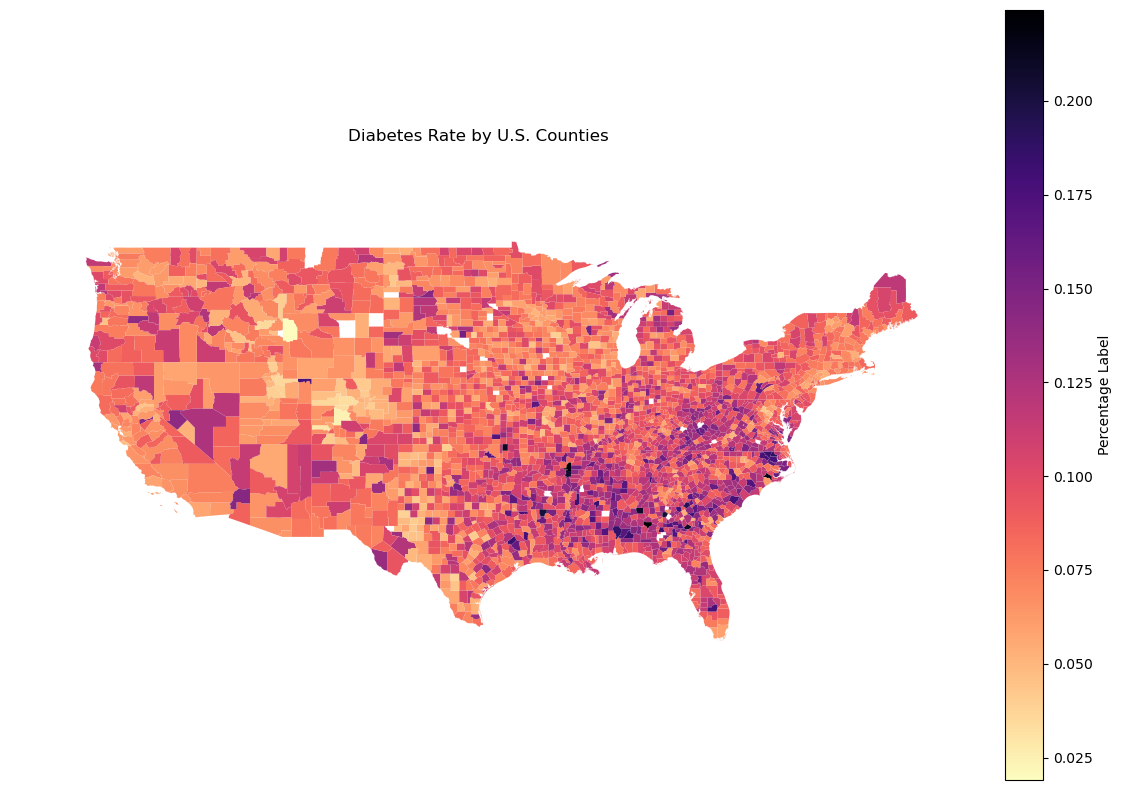

In [38]:
#Plot figure of diabetes percentage across counties
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_df.plot(column='Diabetes_Number', cmap='magma_r', linewidth=0.01, ax=ax, edgecolor='0.8')
ax.axis('off')
plt.xlim(-130, -65)
plt.ylim(25, 55) 
ax.set_title('Diabetes Rate by U.S. Counties')
sm = plt.cm.ScalarMappable(cmap='magma_r', norm=plt.Normalize(vmin=merged_df['Diabetes_Number'].min(), vmax=merged_df['Diabetes_Number'].max()))
sm._A = []
cbar = plt.colorbar(sm)

# Set the label for the colorbar
cbar.set_label('Percentage Label')
fig.tight_layout()
plt.show()

### Get summary statistics for diabetes rates across counties

In [39]:
diabetes['Diabetes_Number'].describe()

count    3112.000000
mean        0.092857
std         0.028097
min         0.019038
25%         0.072169
50%         0.089291
75%         0.110175
max         0.224208
Name: Diabetes_Number, dtype: float64

### Discussion
Diabetes varies significantly from county to county. County prevalence ranges from just 2% to 22%. The map shows that counties with high diabetes rates tend to be highly clustered. Such clusters exist throughout the midwest and western states, but counties with high diabetes rates are most prevalent in the south. Consequently, policymakers might want to focus on the southern states  for the roll out of the pilot program in order to learn how to combat diabetes in areas where it is most concentrated.

## Investigate relationship between Hispanic population and diabetes
The following chart shows how diabetes prevalence varies with the percentage of a county that is Hispanic or Latino. Understanding the demographic makeup of counties with high diabetes rate is crucial for treating and preventing the disease. Understanding if diabetes tends to be high among certain ethnic groups or ages can help policymakers to construct prevention programs that are culturally appropriate and that work in partnership with the right community organizations and leaders. 

The graph below shows a weak relationship between the percentage of a county that identifies as Hispanic/Latino and the diabetes rate. Furthermore, the correlation is slightly negative. This indicates that prevention of diabetes among Hispanic/Latino populations might not warrant special consideration for ploiycmakers. Note that this is an average of the relationship and that there are some counties with both large Hispanic/Latino poulations and high diabetes prevalence. Consequently, the demographic makeup and cultural context of each county should be considered in turn when rolling out prevention programs.

<AxesSubplot:xlabel='hispanic or latino and race_total population_hispanic or latino (of any race)', ylabel='Diabetes_Number'>

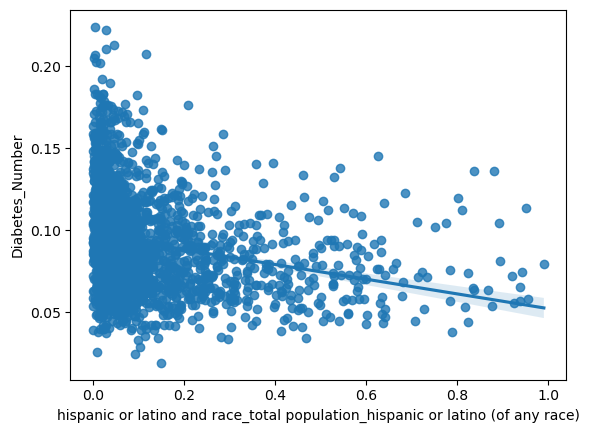

In [40]:
sns.regplot(x = diabetes['hispanic or latino and race_total population_hispanic or latino (of any race)'],
           y = diabetes['Diabetes_Number'])

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'State' to be a categorical variable using `pd.get_dummies` and drop 'County' using `.drop()` because 'CountyFIPS' is already a unique identifier for the county. 

In [122]:
# create dummy features out of 'State' , which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # only create 49 dummies by dropping first in category

In [123]:
assert diabetes_clean['race alone or in combination with one or more other races_total population'].all() == 1

In [124]:
# drop 'County' variable
diabetes_clean = diabetes_clean.drop(labels = ['County'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other 

### 3.2/3.3 Partition Data and Feature Selection

Now, we will partition our data to prepare it for the training process. We will use 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough. This case is difficult since we only have a few thousand observations. It would help if we had more years worth of data.

The training set is the portion of the data we use to fit our model. The alogirthm will solve the parameters of the objective function using the observations in the training data. In the case of OLS, this is the vector $\beta$ that minimizes the residual sum of squares. Formally, we solve the following criterion function using the training data:
$$
\min_{\beta} \sum_{i=1}^n (y_i - \beta x_{i})^2
$$

The validation set is used to test how well the fitted model works with different tuning parameters. Testing the model in an interim stage helps us to assess how to set tuning parameters such as the rate of regularization in the case of Ride or LASSO in order to ensure that the fitted model generalizes well to out of sample data.

The test set is the final portion of the data used to formally assess how well our fitted algorithm performs on non-training data. This is intended to capture how well the model will work when we take it to new data

In [125]:
# Set y 
y = diabetes_clean['Diabetes_Number']

# X (everything except diabetes, our target)
X = diabetes_clean.drop(columns = ['Diabetes_Number', 'CountyFIPS', 'State'])
features_df = diabetes_clean.drop(columns = ['Diabetes_Number', 'State', 'CountyFIPS', 'race alone or in combination with one or more other races_total population'])

In [126]:
X

,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race - and three or more races,to

In [127]:
X.shape

(3112, 89)

In [128]:
selector = feature_selection.VarianceThreshold(0)
X = selector.fit_transform(X)

In [129]:
X.shape

(3112, 88)

In [130]:
# split the data
# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

In [131]:
#X = preprocessing.scale(X)

In [132]:
np.mean(X[:,20])

0.00259801027770597

In [133]:
#Now split the training sample into a validation and a true training set
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = .25, random_state = 456)

We will want to standardize our data to be mean centered and have unit variance. Forcing all features to be on the same scale helps to ensure that no one feature dominates the objective function. This ensures that the algorithm can learn from all of the features 

In [134]:
scaler = StandardScaler().fit(X_train) 

In [135]:
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [136]:
np.mean(X_train[:,5])

-3.366129573483004e-15

In [137]:
np.mean(X_validate[:,25])

0.049303319477338584

## 4. Train Models

### 4.1 Describe the selected models

### OLS
OLS fits a linear model to the data that minimizes the sum of squared errors, or the sum of squared differences between the model prediction and the actual observations. OLS assumes that the true relationship between the regressors and the independent variable is linear. OLS may poorly fit the data if the true relationship is not linear. One advantage is that the coefficients from OLS are easily interpretable. Under OLS, terms have an additive correlation with the outcome of interest and a one unit change in a regressor has the same effect on the outcome no matter the level of the regressor. 


### RIDGE
Similar to OLS, ridge regression fits a linear model (technically it does not need to be linear as you could have ridge for logit or other non-linear models). The objective function of the ridge regression is to minimize the sum of squared residuals plus a term that depends on the absolute size of each coeffcient subject to a tuning parameter. In essence, this prevents any coefficient $\beta_j$ from being too large if the relevant predictor does not explain a sufficient amount of the variation in the outcome variable. Overall, this has the effect of minimizing the coefficients on unimportant predictors which reduces overfitting. One con to ridge regression is that coefficients are less interpretable. Also, the ridge regression will include all the covariates in the final estimate instead of just including the important covariates as opposed to LASSO. Additionally, the ridge regression will introduce bias into the coefficient estimates. Some predictors may not explain a significant portion of the variation in the outcome, but nonethless may be important correlates between a specific predictor of interest and the outcome simultaneously. This will bias the causal interpretation of the coefficient on that predictor of interest.

### LASSO
The LASSO works similar to the ridge regression in that it minimizes the sum of squared residuals subject to a penalty on the size of the coefficients. But where the ridge regression penalizes the squared size of the coefficients, the LASSO penalizes the absolute size. Because the absolute value has a kink at 0, many potential predictors do not explain sufficient variation in the outcome to justify their inclusion in the model. This often results in LASSO only selecting a subset of the potential predictors. Similar to ridge, the coefficients on the LASSO are less interpretable than OLS and the use of regularization introduces extra bias as the cost of lowering the out-of-sample variance in predictions.

### 4.2 Train the models

In [138]:
# Train OLS 
ols_reg = linear_model.LinearRegression()
ols_reg.fit(X_train, y_train)
diabetes_ols_pred = ols_reg.predict(X_validate)

ols_train_pred = ols_reg.predict(X_train)
ssr = np.sum((y_train - ols_train_pred)**2)
sst = np.sum((y_train - np.mean(y_train))**2)
manual_ols_r2 = 1 - (ssr/sst)
canned_ols_r2 = r2_score(y_train, ols_train_pred)
assert canned_ols_r2 == manual_ols_r2
manual_ols_r2

0.5332275540512519

In [139]:
#Train Lasso
lasso_reg = Lasso(alpha=.001)
lasso_reg.fit(X_train, y_train)
lasso_train_pred = lasso_reg.predict(X_train)
lasso_train_r2 = r2_score(y_train, lasso_train_pred)
lasso_train_r2

0.4982403276463474

In [140]:
diabetes_lasso_pred = lasso_reg.predict(X_validate)

In [141]:
# Find the non-zero coefficients and see what variables are being selected
features_df.iloc[:,lasso_reg.coef_!=0].columns

Index(['Obesity_Number', 'Physical_Inactivity_Number',
       'race_total population_one race_white',
       'race_total population_one race_black or african american',
       'race_total population_one race_american indian and alaska native_navajo tribal grouping',
       'race_total population_two or more races_white and asian',
       'citizen -  voting age population_citizen -  18 and over population_female',
       'sex and age_total population_20 to 24 years',
       'sex and age_total population_65 to 74 years',
       'sex and age_total population_85 years and over',
       'sex and age_total population_65 years and over_female', 'Region_South',
       'Region_Southeast'],
      dtype='object')

In [142]:
#Train Ridge 
ridge_reg = Ridge(alpha=.001)
ridge_reg.fit(X_train, y_train)
ridge_train_pred = ridge_reg.predict(X_train)
ridge_train_r2 = r2_score(y_train, ridge_train_pred)
ridge_train_r2

0.5355242822669417

In [143]:
diabetes_ridge_pred = ridge_reg.predict(X_validate)

## 5. Validate and Refine Models

### 5.1 Test the models on the validation set 
Manually calculate the test MSE then use the canned sklearn function to check

In [144]:
#OLS
manual_ols_validate_mse = np.mean((y_validate - diabetes_ols_pred)**2)
canned_ols_validate_mse = mean_squared_error(y_validate, diabetes_ols_pred)
assert manual_ols_validate_mse == canned_ols_validate_mse
canned_ols_validate_mse

0.0004142969155541936

In [145]:
#LASSO 
manual_lasso_validate_mse = np.mean((y_validate - diabetes_lasso_pred)**2)
canned_lasso_validate_mse = mean_squared_error(y_validate, diabetes_lasso_pred)
assert manual_lasso_validate_mse == canned_lasso_validate_mse
canned_lasso_validate_mse

0.00039321772770181765

In [146]:
#Ridge
manual_ridge_validate_mse = np.mean((y_validate - diabetes_ridge_pred)**2)
canned_ridge_validate_mse = mean_squared_error(y_validate, diabetes_ridge_pred)
assert manual_ridge_validate_mse == canned_ridge_validate_mse
canned_ridge_validate_mse

0.0004113378424674975

The lasso had the lowest mean squared error in the validation set. OLS, Ridge, and LASSO all performed comparably which is unsurprising given that we didn't add interaction terms or nonlinear terms. Adding these features may have caused ols to overfit the training data and perform poorly out of sample. Adding polynomials and interaciton terms would have made this a problem more suited to the regularization approaches of LASSO and Ridge that help to prevent overfitting by constraining the flexibility of the model. Since these features were not included and lambda was set very low for both the Ridge and LASSO, we should expect these approaches to perform similarly to OLS.

That LASSO performed slightly better than OLS out of sample is an indication that OLS slightly overfit the training sample relative to LASSO.

### 5.2 Test Set

I'm a little confused by this part. Why would we select out the unimportant features and retrain the model? This is already what LASSO is doing. What does this add?

In [147]:
# Remove unimportant features
X_train_selected = X_train[:,lasso_reg.coef_!=0]

In [148]:
#Re-train Lasso
lasso_reg_selected = Lasso(alpha=.001)
lasso_reg_selected.fit(X_train_selected, y_train)
lasso_selected_pred = lasso_reg.predict(X_test)

In [149]:
#Calculate test MSE
lasso_test_mse = mean_squared_error(y_test, lasso_selected_pred)
lasso_test_mse

0.0003841782581876115

In [150]:
#Evaluate test R^2
lasso_test_r2 = r2_score(y_test, lasso_selected_pred)
lasso_test_r2

0.4799262622136171

Our LASSO specification can explain a little under 48% of the variation in diabetes prevalence by county in the test data set. This is a significant amount of the overall variation given the limited number of possible features. One advantage of using both the validation and test sets in a public policy application is that the cost of implementing a policy based on an innacruate algorithm may be quite high. If the policymaker is risk-averse, we want to be confident that our predictions will generalize well to other settings. Using both the test and validation sets helps to ensure that our out of sample error rate is adequate enough to justify using the algorithm for policy decisions.

### 5.3 Implement a Cross-Validation Approach

I will use cross validation to both select the value of the LASSO tuning parameter (lambda) a validation error rate. Implementing a CV approach to find the best lambda is a bad idea if we are concerned about specifying the correct model or saying something causal about diabetes prevalance. This is because a CV-selected lambda will optimize the prediction power of the model, but may shrink coefficients on important variables to zero. Here, we are only concerned with predicting the rate of diabetes in a county. Using a cross-validation approach to select the tuning parameter is appropriate.

Because we are using cross validation, we can take advantage of the full size of the training set. Rather than split the data into dedicated train/validate/test partiitions we can just perform a train/test split. The cross validation approach will take advantage of the full set of training data to both train and validate the model

In [151]:
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X, y, test_size=.2, random_state=123)

In [152]:
#Need to re-standardize
cv_scaler = StandardScaler().fit(X_cv_train) 
X_cv_train = cv_scaler.transform(X_cv_train)
X_cv_test = cv_scaler.transform(X_cv_test)

In [153]:
X_cv_test.shape

(623, 88)

In [154]:
y_cv_test

236     0.093938
365     0.088394
327     0.113188
724     0.117758
2224    0.099367
          ...   
2136    0.097156
118     0.066805
1234    0.096708
2798    0.126821
736     0.126952
Name: Diabetes_Number, Length: 623, dtype: float64

### Choosing number of folds for cross validation
The choice of folds when performing k-fold cross validation is a trade-off between bias and variance. The more folds there are, the fewer observations there will be in each fold. When the data is trained on K-1 folds with large k, the k-1 folds will contain most of the training data. Containing more data means that the bias will be lower as the algorithm can more accurately fit the data. However, this means that overfitting may be a problem as large k more closely approximates a leave-one-out cross validation approach where prediction on the single observation that is left out may suffer from high variance as any single observation may not be typical of the underlying distribtion of data.

This is less of a problem with larger datasets where each fold will contain sufficiently many observations to be approximately representative of the uderlying distribution. 


In [155]:
lasso_cv_specification = LassoCV(cv=5, random_state=0, max_iter=10000)
lasso_cv_specification.fit(X_cv_train, y_cv_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [156]:
best_alpha = lasso_cv_specification.alpha_
best_alpha

0.00019198443316857506

In [157]:
cv_lasso = Lasso(alpha = best_alpha)
cv_lasso.fit(X_cv_train, y_cv_train)
cv_lasso_train_pred = lasso_reg.predict(X_cv_train)
cv_lasso_test_pred = lasso_reg.predict(X_cv_test)

In [158]:
# Find the non-zero coefficients and see what variables are being selected
features_df.iloc[:,cv_lasso.coef_!=0].columns

Index(['Obesity_Number', 'Physical_Inactivity_Number',
       'sex and age_total population_65 years and over_sex ratio (males per 100 females)',
       'race_total population', 'race_total population_one race_white',
       'race_total population_one race_american indian and alaska native_cherokee tribal grouping',
       'race_total population_one race_american indian and alaska native_chippewa tribal grouping',
       'race_total population_one race_american indian and alaska native_navajo tribal grouping',
       'race_total population_one race_american indian and alaska native_sioux tribal grouping',
       'race_total population_one race_asian_asian indian',
       'race_total population_one race_asian_chinese',
       'race_total population_one race_asian_filipino',
       'race_total population_one race_asian_japanese',
       'race_total population_one race_asian_vietnamese',
       'race_total population_one race_asian_other asian',
       'race_total population_one race_nati

In [159]:
# Get the training R^2 (in a slightly different way for practice)
train_mse = round(mean_squared_error(y_cv_train, cv_lasso_train_pred), 6)
print("The training set mean squared error in the cross validation approach is:", train_mse)

The training set mean squared error in the cross validation approach is: 0.000407


In [160]:
train_r2 = round(cv_lasso.score(X_cv_train, y_cv_train)*100, 2)
print("The training set R-Squared in the cross validation approach is:", train_r2)

The training set R-Squared in the cross validation approach is: 51.69


In [161]:
#Evaluate performance in test set
test_mse = round(mean_squared_error(y_cv_test, cv_lasso_test_pred), 6)
print("The test set mean squared error in the cross validation approach is:", test_mse)

test_r2 = round(cv_lasso.score(X_cv_test, y_cv_test)*100, 2)
print("The test set R-Squared in the cross validation approach is:", test_r2)

The test set mean squared error in the cross validation approach is: 0.000384
The test set R-Squared in the cross validation approach is: 48.03


In [162]:
coef_dict = {
    "Feature": list(features_df.columns),
    "Coefficient": cv_lasso.coef_
}

In [163]:
# Create a DataFrame and sort by coefficient magnitude in descending order
coefficients_df = pd.DataFrame(coef_dict)
coefficients_df = coefficients_df.reindex(coefficients_df["Coefficient"].abs().sort_values(ascending=False).index)

In [164]:
coefficients_df

,Feature,Coefficient
0,Obesity_Number,0.008060
1,Physical_Inactivity_Number,0.007303
83,sex and age_total population_65 years and over...,0.005109
86,Region_Southeast,0.002511
71,sex and age_total population_85 years and over,-0.002506
6,race_total population_one race_white,-0.002235
85,Region_South,0.002146
32,race alone or in combination with one or more ...,0.001843
69,sex and age_total population_65 to 74 years,0.001725
43,hispanic or latino and race_total population_n...,-0.001640


## 6. Discussion Questions

### 6.1 What is the bias-variance tradeoff? Why is it relevant to machine learning poblems like this one?
You can decrease bias, or the degree to which the fitted values of your model differ from the actual values, by incorporating more information, or predictors, into your model. Doing this in a sample, there is some degree to which you are capturing the way the real world works, and some degree to which you are explaining random variation in your particular sample. If you include lots of predictors that explain random variation, then your predcition model will not be consitent when you use it on other samples since those new samples will have random variation that looks very different from your original data. This is is the bias-variance trade-off. This is relevant to machine learning because we care about creating prediction models that capture the way the world truly works, and that give us consistent and accurate predictions across models.

### 6.2 Define overfitting, and why it matters for machine learning. How can we address it?
Overfitting is tailoring your estimate of a model to fit the idiosyncracies of a particular dataset that are a product of random error or potentially measurment error rather than the underlying data generating process. In the context of diabetes, we might think of diabetes as caused primarily by diet, exercise, and genetic factors. However, we may, by random chance, get a sample of data on diabetes prevalence that happens to contain lots of individuals who are accounttants and have diabetes. This does not mean that diabetes is caused by becoming an accountant. This is just a feature of the particular sample we happened to draw. Overfitting in this particular example means that we fit a model that uses being an accountant as a strong predictor of diabetes. 

In machine learning, we are primarily concenred with prediction. In our toy example, our model is unlikely to predict diabetes well when we apply it to other datasets because being an accountant has no direct link with diabetes. In practice, the random noise we get in any given dataset is likely to be more subtle than the accountant example. Nevertheless, our algorithm may chase down this random noise rather than focusing on information that truly predicts our outcome.

One simple way to address overfitting is to average models over many many samples. If we take multiple samples, the idisyncracies from any one sample will eventually cancel each other out. Some samples may have lots of accountants with diabetes leading to a model that uses being an accountant as an improtant predictor of diabetes. Other samples may have very few accountants and will conclude this is not an improtant predictor. Other samples may have lots of accountants who do not have diabetes and conclude being an accountant is a protective factor. By averaging these the predictions across these samples together, the noise (being an accountant) will not being given much weight. 

Another way to prevent overfitting is to only place weight on predictors that expalin a significant amount of variation in the outcome, this is regularization. Being an accountant may explain some variation in diabetes in a given sample, but it is unlikely to explain that much. Regularization will help to produce a model where predictors that explain small pockets of noise are given little to no improtance for prediction.



### 6.3 Discussion of analysis
According to the algorithm, predictors like the obesity and physcial activity number, as well as whether the county is in the South or Southeast are indicative of higher diabetes rates. It would be natural to pilot the programs in these areas. However, we know the actual diabetes rate and we are interested in preventing diabetes. It would likely be best to prioritize piloting the program in areas where obesity and physical inactivity are increasing, but where diabetes is not necessarily high as these factors may be leading predictors of diabetes. However, the algorithm does not tell us this and certainly does not tell us the causal relationship between diabetes and these factors. 

Race, gender, and age are important predictors of diabetes rates according to the algorithm, the ommision or inclusion of these predictors would likely change how accurate the algorithm is at predicting diabetes rates. While this algorithm is a good start for predciting diabetes rates, it does not predict future diabetes rates or factors that cause diabetes that might be changeable through the prevention program. Consequently, it would be better to run this algorithm on panel data and to know more about the design of the prevention problem. That being said, if we truly need to a contemporaneous predictor of diabetes rates, this algorithm may be our best availble option.